In [1]:
# enrichment and feature ranking
import pandas as pd
from pickle import load
import cobra
import medusa
import os
import json
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker as mticker
matplotlib.rcParams["savefig.dpi"] = 300
matplotlib.rcParams['figure.dpi'] = 300
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"


import seaborn as sns

SMALLER_SIZE = 8
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 16

matplotlib.rc('font', size=SMALL_SIZE)          # controls default text sizes
matplotlib.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
matplotlib.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
matplotlib.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=SMALLER_SIZE)    # legend fontsize
matplotlib.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

%matplotlib inline

In [2]:
# load the universal model -- will be needed to get metabolites associated with each reaction
universal = cobra.io.load_json_model('../data/universal_mundy.json')

In [3]:
ensembles = {}
importances = {}
cluster_membership = {}
collapsed_features = {}
# exclude species that had non-variant ensemble structure or predictions.
exclude = ['Bacillus megaterium','Stenotrophomonas maltophilia','Achromobacter xylosoxidans','Achromobacter piechaudii']
for species_file in os.listdir("../results/deep_ensembles/"):
    species_name = species_file.split(".")[0]
    
    if species_name not in exclude:
        with open("../results/deep_ensembles/"+species_name+".pickle",'rb') as infile:
            print(species_name)
            ensembles[species_name] = load(infile)

        # load the feature importance data for all species
        importances[species_name] = pd.read_csv('../results/classification_results/'+species_name+'_feature_importance.csv',sep=',', index_col = 0)

        # save the cluster membership information
        cluster_membership[species_name] = pd.read_csv('../results/classification_results/'+species_name+'_clusters.csv',sep=',')

        # load the collapsed feature sets
        with open('../results/collapsed_features/'+species_name+'_collapsed_features.json','r') as jsonfile:
            collapsed_features[species_name] = json.load(jsonfile)

Streptococcus equinus
Aeromonas salmonicida
Flavobacterium johnsoniae
Ralstonia solanacearum
Streptococcus mitis
Bacillus pumilus
Enterococcus faecalis
Pseudomonas putida
Haemophilus parasuis
Chryseobacterium gleum
Staphylococcus haemolyticus
Neisseria mucosa
Listeria monocytogenes
Neisseria flavescens
Streptococcus pneumoniae
Haemophilus influenzae
Sphingobacterium spiritivorum
Ralstonia pickettii
Corynebacterium glutamicum
Staphylococcus epidermidis
Pseudomonas mendocina
Streptococcus gallolyticus
Staphylococcus aureus
Streptococcus oralis
Neisseria meningitidis
Corynebacterium efficiens
Streptococcus vestibularis
Pseudomonas stutzeri
Listeria seeligeri


In [4]:
# get the average fractional importance for each reaction.
# first, expand collapsed features and duplicate their fractional importance
reaction_fractional_importances = {}
reaction_fractional_differences = {}
reaction_fractional_ratio = {}
# save the same data to species-specific dictionaries so 
# we can more easily generate species-specific dataframes later
species_fractional_importances = {}
species_fractional_differences = {}
species_fractional_ratio = {}
for species in importances.keys():
    species_fractional_importances[species] = {}
    species_fractional_differences[species] = {}
    species_fractional_ratio[species] = {}
    for reaction in importances[species].index.values:
        # extract all reactions from the collapsed feature set
        subreactions = collapsed_features[species][reaction]
        # if all subreactions are lower bound features, remove the set. This set
        # just represents the lower bound of 0 for all irreversible reactions with a
        # feature.
        if 'upper_bound' in " ".join(subreactions):
            # get rid of upper/lower bound and _c suffix
            subreactions = [r.split('_')[0] for r in subreactions]
            # remove redundant features (upper/lower bound)
            subreactions = list(set(subreactions))

            for r in subreactions:
                # remember: all 'r's get assigned the same importance/difference as the label for the feature set, 'reaction'
                if r in reaction_fractional_importances.keys():
                    reaction_fractional_importances[r].append(importances[species].loc[reaction]['importance'])
                    reaction_fractional_differences[r].append(abs(importances[species].loc[reaction]['fraction active in 0'] -
                                                                 importances[species].loc[reaction]['fraction active in 1']))
                    reaction_fractional_ratio[r].append(1 - min(importances[species].loc[reaction]['fraction active in 0'],
                                                                 importances[species].loc[reaction]['fraction active in 1'])/
                                                             max(importances[species].loc[reaction]['fraction active in 0'],
                                                                 importances[species].loc[reaction]['fraction active in 1']))
                else:
                    reaction_fractional_importances[r] = [importances[species].loc[reaction]['importance']]
                    reaction_fractional_differences[r] = [abs(importances[species].loc[reaction]['fraction active in 0'] -
                                                                 importances[species].loc[reaction]['fraction active in 1'])]
                    reaction_fractional_ratio[r] = [1 - min(importances[species].loc[reaction]['fraction active in 0'],
                                                                 importances[species].loc[reaction]['fraction active in 1'])/
                                                             max(importances[species].loc[reaction]['fraction active in 0'],
                                                                 importances[species].loc[reaction]['fraction active in 1'])]
                    



                species_fractional_importances[species][r] = importances[species].loc[reaction]['importance']
                species_fractional_differences[species][r] = abs(importances[species].loc[reaction]['fraction active in 0'] -
                                                                 importances[species].loc[reaction]['fraction active in 1'])
                species_fractional_ratio[species][r] = (1 - min(importances[species].loc[reaction]['fraction active in 0'],
                                                                 importances[species].loc[reaction]['fraction active in 1'])
                                                             /max(importances[species].loc[reaction]['fraction active in 0'],
                                                                 importances[species].loc[reaction]['fraction active in 1']))

In [5]:
# Calculate means across the pan-species data
mean_fractional_importances = {r:np.mean(reaction_fractional_importances[r]) for r in reaction_fractional_importances.keys()}
mean_fractional_differences = {r:np.mean(reaction_fractional_differences[r]) for r in reaction_fractional_differences.keys()}
mean_fractional_ratios = {r:np.mean(reaction_fractional_ratio[r]) for r in reaction_fractional_ratio.keys()}
reaction_model_counts = {r:len(reaction_fractional_importances[r]) for r in reaction_fractional_importances.keys()}
zero_weighted_importances = {r:np.sum(reaction_fractional_importances[r])/len(importances.keys()) for r in reaction_fractional_importances.keys()}
zero_weighted_differences = {r:np.sum(reaction_fractional_differences[r])/len(importances.keys()) for r in reaction_fractional_differences.keys()}
for_df = {'mean fractional importance':mean_fractional_importances,
          'mean fractional difference':mean_fractional_differences,
          'zero-weighted importance':zero_weighted_importances,
          'zero-weighted difference':zero_weighted_differences,
          'species count':reaction_model_counts,
          'mean cluster ratio':mean_fractional_ratios}
means_as_df = pd.DataFrame.from_dict(for_df)

species_curation_dfs = {}
for species in species_fractional_importances.keys():
    for_df = {'fractional importance':species_fractional_importances[species],
          'fractional difference':species_fractional_differences[species],
          'cluster ratio':species_fractional_ratio[species]}
    species_curation_dfs[species] = pd.DataFrame.from_dict(for_df)
    
# also calculate mean importances and ratios differences for each metabolite in every reaction
metabolite_importances = {}
metabolite_ratios = {}
for r in reaction_fractional_importances.keys():
    metabolites = universal.reactions.get_by_id(r+'_c').metabolites
    for metabolite in metabolites:
        if metabolite.id in metabolite_importances.keys():
            metabolite_importances[metabolite.id].extend(reaction_fractional_importances[r])
            metabolite_ratios[metabolite.id].extend(reaction_fractional_ratio[r])
        else:
            metabolite_importances[metabolite.id] = reaction_fractional_importances[r]
            metabolite_ratios[metabolite.id] = reaction_fractional_ratio[r]

mean_met_importances = {m:np.mean(metabolite_importances[m]) for m in metabolite_importances.keys()}
mean_met_ratios = {m:np.mean(metabolite_ratios[m]) for m in metabolite_ratios.keys()}
met_rxn_membership_counts = {m:len(metabolite_importances[m]) for m in metabolite_importances.keys()}
met_target_df = pd.DataFrame.from_dict({'mean fractional importance':mean_met_importances,
                                        'mean cluster ratio':mean_met_ratios,
                                        'number of reactions':met_rxn_membership_counts})

In [6]:
# Compile the top 10 curation targets from each species into a single dataframe
# for easier manual searching
i = 0
for species in species_curation_dfs.keys():
    if i == 0:
        df = species_curation_dfs[species].sort_values(by = 'fractional importance', ascending = False).head(10)
        df['species'] = species
    else:
        df2 = species_curation_dfs[species].sort_values(by = 'fractional importance', ascending = False).head(10)
        df2['species'] = species
        df = pd.concat([df,df2])
    i += 1
    
# add a reaction string for each reaction
rxn_strings = []
univ_reactions = [rxn.id for rxn in universal.reactions]
for reaction in df.index:
    if reaction+'_c' in univ_reactions:
        rxn_as_string = universal.reactions.get_by_id(reaction+'_c').build_reaction_string(use_metabolite_names=True)
    else:
        rxn_as_string = 'Reaction missing from universal'
    rxn_strings.append(rxn_as_string)

df['reaction string'] = rxn_strings

df.to_csv('../results/classification_results/panspecies_top10_targets.csv',sep=',')

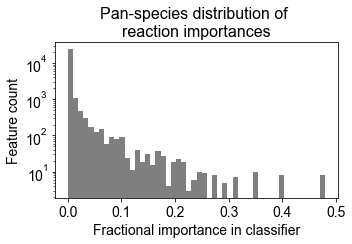

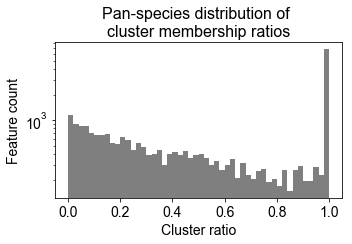

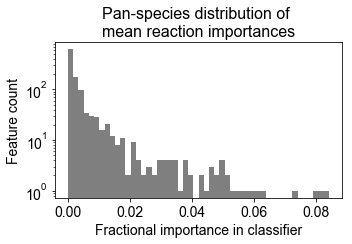

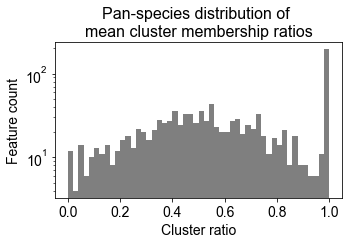

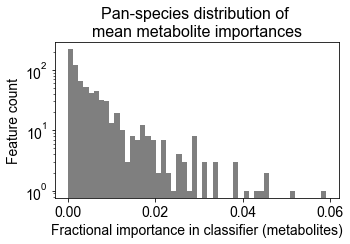

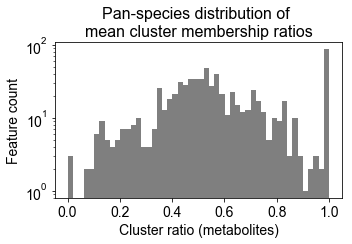

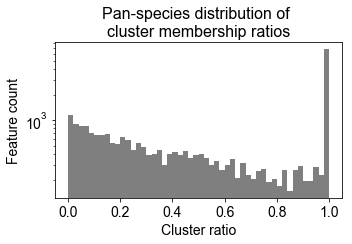

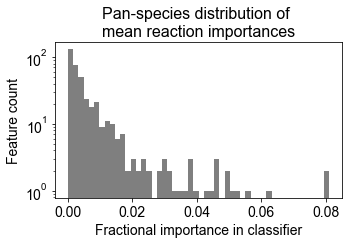

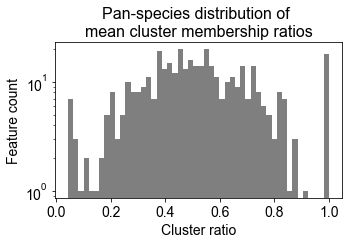

In [7]:
# plot the distribution of fractional importances and fractional ratios across the entire dataset
fig,ax = plt.subplots()
vals = []
for r in reaction_fractional_importances.keys():
    vals.extend(reaction_fractional_importances[r])
ax.hist(vals,bins=50, color='black', alpha = 0.5)
plt.yscale('log', basey=10)
ax.set_xlabel('Fractional importance in classifier')
ax.set_ylabel('Feature count')
#ax.xaxis.set_major_formatter(mticker.ScalarFormatter()) # <- neither of this get rid of log notation...
#ax.xaxis.set_minor_formatter(mticker.ScalarFormatter())

ax.set_title('Pan-species distribution of \nreaction importances')
fig.set_size_inches(5,3.5)
plt.tight_layout()

plt.savefig('../results/curation_target_plots/feature_importance_distribution_SEED.svg')
plt.savefig('../results/curation_target_plots/feature_importance_distribution_SEED.png')

fig,ax = plt.subplots()
vals = []
for r in reaction_fractional_ratio.keys():
    vals.extend(reaction_fractional_ratio[r])
ax.hist(vals,bins=50, color='black', alpha = 0.5)
plt.yscale('log', basey=10)
ax.set_xlabel('Cluster ratio')
ax.set_ylabel('Feature count')
ax.set_title('Pan-species distribution of \ncluster membership ratios')
fig.set_size_inches(5,3.5)
plt.tight_layout()

plt.savefig('../results/curation_target_plots/feature_ratio_distribution_SEED.svg')
plt.savefig('../results/curation_target_plots/feature_ratio_distribution_SEED.png')


## Plot means for reactions

fig,ax = plt.subplots()
vals = []
for r in mean_fractional_importances.keys():
    vals.extend([mean_fractional_importances[r]])
ax.hist(vals,bins=50, color='black', alpha = 0.5)
plt.yscale('log', basey=10)
ax.set_xlabel('Fractional importance in classifier')
ax.set_ylabel('Feature count')
ax.set_title('Pan-species distribution of \nmean reaction importances')
fig.set_size_inches(5,3.5)
plt.tight_layout()

plt.savefig('../results/curation_target_plots/reaction_mean_importance_distribution_SEED.svg')
plt.savefig('../results/curation_target_plots/reaction_mean_importance_distribution_SEED.png')

fig,ax = plt.subplots()
vals = []
for r in mean_fractional_ratios.keys():
    vals.extend([mean_fractional_ratios[r]])
ax.hist(vals,bins=50, color='black', alpha = 0.5)
plt.yscale('log', basey=10)
ax.set_xlabel('Cluster ratio')
ax.set_ylabel('Feature count')
ax.set_title('Pan-species distribution of \nmean cluster membership ratios')
fig.set_size_inches(5,3.5)
plt.tight_layout()

plt.savefig('../results/curation_target_plots/reaction_mean_ratio_distribution_SEED.svg')
plt.savefig('../results/curation_target_plots/reaction_mean_ratio_distribution_SEED.png')

## Plot means for metabolites -- raw values will be the exact same distribution 
# as for reactions (verified), so not needed.

fig,ax = plt.subplots()
vals = []
for m in mean_met_importances.keys():
    vals.extend([mean_met_importances[m]])
ax.hist(vals,bins=50, color='black', alpha = 0.5)
plt.yscale('log', basey=10)
ax.set_xlabel('Fractional importance in classifier (metabolites)')
ax.set_ylabel('Feature count')
ax.set_title('Pan-species distribution of \nmean metabolite importances')
fig.set_size_inches(5,3.5)
plt.tight_layout()

plt.savefig('../results/curation_target_plots/metabolite_importance_distribution_SEED.svg')
plt.savefig('../results/curation_target_plots/metabolite_importance_distribution_SEED.png')

fig,ax = plt.subplots()
vals = []
for m in mean_met_ratios.keys():
    vals.extend([mean_met_ratios[m]])
ax.hist(vals,bins=50, color='black', alpha = 0.5)
plt.yscale('log', basey=10)
ax.set_xlabel('Cluster ratio (metabolites)')
ax.set_ylabel('Feature count')
ax.set_title('Pan-species distribution of \nmean cluster membership ratios')
fig.set_size_inches(5,3.5)
plt.tight_layout()

plt.savefig('../results/curation_target_plots/metabolite_ratio_distribution_SEED.svg')
plt.savefig('../results/curation_target_plots/metabolite_ratio_distribution_SEED.png')


fig,ax = plt.subplots()
vals = []
for r in reaction_fractional_ratio.keys():
    vals.extend(reaction_fractional_ratio[r])
ax.hist(vals,bins=50, color='black', alpha = 0.5)
plt.yscale('log', basey=10)
ax.set_xlabel('Cluster ratio')
ax.set_ylabel('Feature count')
ax.set_title('Pan-species distribution of \ncluster membership ratios')
fig.set_size_inches(5,3.5)
plt.tight_layout()

plt.savefig('../results/curation_target_plots/feature_ratio_distribution_SEED.svg')
plt.savefig('../results/curation_target_plots/feature_ratio_distribution_SEED.png')

## Plot means for reactions, this time filtered by reactions gapfilled for at least 5 species

fig,ax = plt.subplots()
vals = []
for r in mean_fractional_importances.keys():
    if reaction_model_counts[r] > 4:
        vals.extend([mean_fractional_importances[r]])
ax.hist(vals,bins=50, color='black', alpha = 0.5)
plt.yscale('log', basey=10)
ax.set_xlabel('Fractional importance in classifier')
ax.set_ylabel('Feature count')
ax.set_title('Pan-species distribution of \nmean reaction importances')
fig.set_size_inches(5,3.5)
plt.tight_layout()

plt.savefig('../results/curation_target_plots/reaction_mean_importance_5spec_SEED.svg')
plt.savefig('../results/curation_target_plots/reaction_mean_importance_5spec_SEED.png')

fig,ax = plt.subplots()
vals = []
for r in mean_fractional_ratios.keys():
    if reaction_model_counts[r] > 4:
        vals.extend([mean_fractional_ratios[r]])
ax.hist(vals,bins=50, color='black', alpha = 0.5)
plt.yscale('log', basey=10)
ax.set_xlabel('Cluster ratio')
ax.set_ylabel('Feature count')
ax.set_title('Pan-species distribution of \nmean cluster membership ratios')
fig.set_size_inches(5,3.5)
plt.tight_layout()

plt.savefig('../results/curation_target_plots/reaction_mean_ratio_5spec_SEED.svg')
plt.savefig('../results/curation_target_plots/reaction_mean_ratio_5spec_SEED.png')


In [8]:
sorted_df = means_as_df.sort_values(by=['mean cluster ratio','mean fractional importance'], ascending=[True,False])

# load subsystem info
subsystems = pd.read_csv('../data/ModelSEED_Subsystems_20190409.tsv', sep='\t')
subsystems.index = subsystems['Reaction'].tolist()

# add a reaction string and subsystem information for each reaction
rxn_strings = []
class_subsystem = [] # highest level of subsystem
subclass_subsystem = []
subsystem_name = []
subsystem_role = []
univ_reactions = [rxn.id for rxn in universal.reactions]

# record mean fractional importance and cluster ratios for subsystems in these dicts
classes = {}
subclasses = {}
subsystem_names = {}

for reaction in sorted_df.index:
    if reaction+'_c' in univ_reactions:
        rxn_as_string = universal.reactions.get_by_id(reaction+'_c').build_reaction_string(use_metabolite_names=True)
    else:
        rxn_as_string = 'Reaction missing from universal'
    rxn_strings.append(rxn_as_string)
    
    if reaction in subsystems.index:
        info = pd.DataFrame(subsystems.loc[reaction]) # necessary for uniform processing
        # of both single entries and multiple entries, e.g. a reaction can have multiple assignments
        if len(info.columns) == 1:
            info = info.T
        class_subsystem.append(list(info['Class']))
        subclass_subsystem.append(list(info['Sub-class']))
        subsystem_name.append(list(info['Name']))
        subsystem_role.append(list(info['Role']))
        
        # for each of the subsystems, add the fractional importance and cluster ratio means
        #for entry in info.index:
        for index, row in info.iterrows():
            if row['Class'] in classes.keys():
                classes[row['Class']]['mean fractional importance'].append(sorted_df.loc[index]['mean fractional importance'])
                classes[row['Class']]['mean cluster ratio'].append(sorted_df.loc[index]['mean cluster ratio'])
            else:
                classes[row['Class']] = {'mean fractional importance':[sorted_df.loc[index]['mean fractional importance']],
                                                     'mean cluster ratio':[sorted_df.loc[index]['mean cluster ratio']]}
                
            if row['Sub-class'] in subclasses.keys():
                subclasses[row['Sub-class']]['mean fractional importance'].append(sorted_df.loc[index]['mean fractional importance'])
                subclasses[row['Sub-class']]['mean cluster ratio'].append(sorted_df.loc[index]['mean cluster ratio'])
            else:
                subclasses[row['Sub-class']] = {'mean fractional importance':[sorted_df.loc[index]['mean fractional importance']],
                                                     'mean cluster ratio':[sorted_df.loc[index]['mean cluster ratio']]}
                
            if row['Name'] in subsystem_names.keys():
                subsystem_names[row['Name']]['mean fractional importance'].append(sorted_df.loc[index]['mean fractional importance'])
                subsystem_names[row['Name']]['mean cluster ratio'].append(sorted_df.loc[index]['mean cluster ratio'])
            else:
                subsystem_names[row['Name']] = {'mean fractional importance':[sorted_df.loc[index]['mean fractional importance']],
                                                     'mean cluster ratio':[sorted_df.loc[index]['mean cluster ratio']]}
    else:
        class_subsystem.append(['Unassigned'])
        subclass_subsystem.append(['Unassigned'])
        subsystem_name.append(['Unassigned'])
        subsystem_role.append(['Unassigned'])
        if 'Unassigned' in classes.keys():
            classes['Unassigned']['mean fractional importance'].append(sorted_df.loc[reaction]['mean fractional importance'])
            classes['Unassigned']['mean cluster ratio'].append(sorted_df.loc[reaction]['mean cluster ratio'])
            subclasses['Unassigned']['mean fractional importance'].append(sorted_df.loc[reaction]['mean fractional importance'])
            subclasses['Unassigned']['mean cluster ratio'].append(sorted_df.loc[reaction]['mean cluster ratio'])
            subsystem_names['Unassigned']['mean fractional importance'].append(sorted_df.loc[reaction]['mean fractional importance'])
            subsystem_names['Unassigned']['mean cluster ratio'].append(sorted_df.loc[reaction]['mean cluster ratio'])
        else:
            classes['Unassigned'] = {'mean fractional importance':[sorted_df.loc[reaction]['mean fractional importance']],
                                     'mean cluster ratio':[sorted_df.loc[reaction]['mean cluster ratio']]}                              
            subclasses['Unassigned'] = classes['Unassigned']
            subsystem_names['Unassigned'] = classes['Unassigned']
sorted_df['reaction string'] = rxn_strings
sorted_df['subsystem class'] = class_subsystem
sorted_df['subsystem sub-class'] = subclass_subsystem
sorted_df['subsystem'] = subsystem_name
sorted_df['role'] = subsystem_role

# add reaction counts to the dictionaries
for key in classes.keys():
    classes[key]['reaction count'] = len(classes[key]['mean fractional importance'])
for key in subclasses.keys():
    subclasses[key]['reaction count'] = len(subclasses[key]['mean fractional importance'])
for key in subsystem_names.keys():
    subsystem_names[key]['reaction count'] = len(subsystem_names[key]['mean fractional importance'])


#sorted_df = sorted_df.sort_values(by='species count', ascending=False)
sorted_df.to_csv('../results/classification_results/panspecies_importances_ratios_means.csv', sep=',')

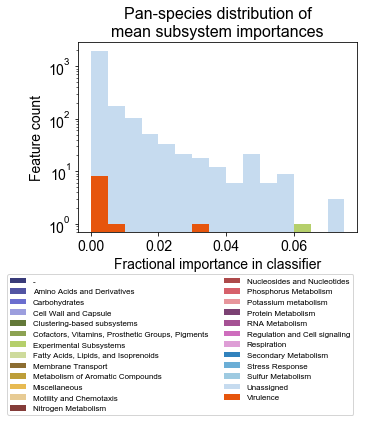

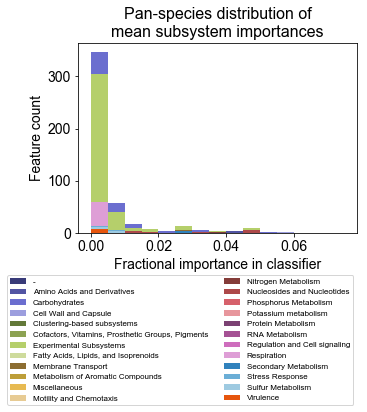

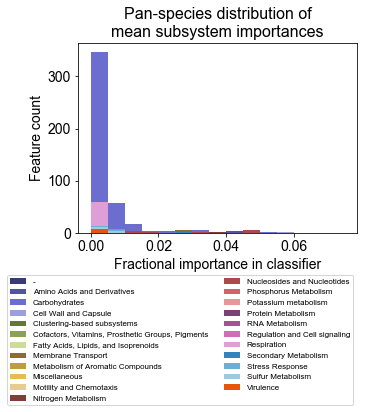

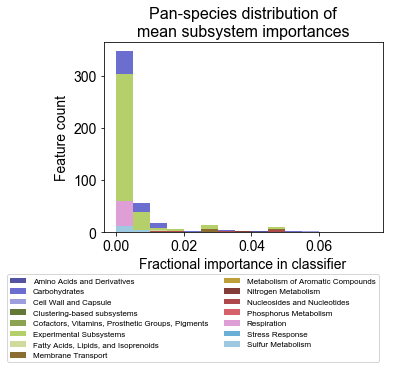

In [9]:
fig, ax = plt.subplots()
colors = plt.cm.get_cmap('tab20b').colors + plt.cm.get_cmap('tab20c').colors
labels = pd.DataFrame(classes).T['mean fractional importance'].index
bins = np.arange(0,0.08,0.005)
i = 0
for label in labels:
    ax.hist(pd.DataFrame(classes).T['mean fractional importance'].loc[label], bins, stacked = True, color=colors[i], label=label)
    i += 1
ax.set_ylabel('Feature count')
ax.set_xlabel('Fractional importance in classifier')
ax.set_title('Pan-species distribution of\nmean subsystem importances')
    
plt.legend(loc='center left', ncol=2, bbox_to_anchor=(1, 0.5))
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.0, -0.2), ncol=2)
plt.yscale('log', basey=10)
fig.set_size_inches(5,3.5)
plt.savefig('../results/subsystems/histogram_class_unassigned.png', bbox_extra_artists=(lgd,), bbox_inches='tight')

# Repeat, this time removing the unassigned label
fig, ax = plt.subplots()
colors = plt.cm.get_cmap('tab20b').colors + plt.cm.get_cmap('tab20c').colors
labels = pd.DataFrame(classes).T['mean fractional importance'].index
bins = np.arange(0,0.08,0.005)
i = 0
for label in labels:
    if label != 'Unassigned':
        ax.hist(pd.DataFrame(classes).T['mean fractional importance'].loc[label], bins, stacked = True, color=colors[i], label=label)
    i += 1
ax.set_ylabel('Feature count')
ax.set_xlabel('Fractional importance in classifier')
ax.set_title('Pan-species distribution of\nmean subsystem importances')

plt.legend(loc='center left', ncol=2, bbox_to_anchor=(1, 0.5))
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.0, -0.2), ncol=2)
#plt.yscale('log', basey=10)
fig.set_size_inches(5,3.5)
plt.savefig('../results/subsystems/histogram_class.png', bbox_extra_artists=(lgd,), bbox_inches='tight')

# Repeat, this time removing the unassigned and "experimental subsystem" labels
fig, ax = plt.subplots()
colors = plt.cm.get_cmap('tab20b').colors + plt.cm.get_cmap('tab20c').colors
labels = pd.DataFrame(classes).T['mean fractional importance'].index
bins = np.arange(0,0.08,0.005)
i = 0
for label in labels:
    if label != 'Unassigned' and label != 'Experimental Subsystems':
        ax.hist(pd.DataFrame(classes).T['mean fractional importance'].loc[label], bins, stacked = True, color=colors[i], label=label)
    i += 1
ax.set_ylabel('Feature count')
ax.set_xlabel('Fractional importance in classifier')
ax.set_title('Pan-species distribution of\nmean subsystem importances')

plt.legend(loc='center left', ncol=2, bbox_to_anchor=(1, 0.5))
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.0, -0.2), ncol=2)
#plt.yscale('log', basey=10)
fig.set_size_inches(5,3.5)
plt.savefig('../results/subsystems/histogram_class_no_exp.png', bbox_extra_artists=(lgd,), bbox_inches='tight')

# Repeat again, this time only including subsystems with more than 10 reaction occurrences
fig, ax = plt.subplots()
colors = plt.cm.get_cmap('tab20b').colors + plt.cm.get_cmap('tab20c').colors
labels = pd.DataFrame(classes).T['mean fractional importance'].index
bins = np.arange(0,0.08,0.005)
i = 0
for label in labels:
    if label != 'Unassigned':
        if len(pd.DataFrame(classes).T['mean fractional importance'].loc[label]) > 10:
            ax.hist(pd.DataFrame(classes).T['mean fractional importance'].loc[label], bins, stacked = True, color=colors[i], label=label)
    i += 1

ax.set_ylabel('Feature count')
ax.set_xlabel('Fractional importance in classifier')
ax.set_title('Pan-species distribution of\nmean subsystem importances')
    
plt.legend(loc='center left', ncol=2, bbox_to_anchor=(1, 0.5))
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.0, -0.2), ncol=2)
#plt.yscale('log', basey=10)
fig.set_size_inches(5,3.5)
plt.savefig('../results/subsystems/histogram_class_greater10.png', bbox_extra_artists=(lgd,), bbox_inches='tight')

In [53]:
def subsys_to_swarmbox(to_df, value_column, 
                       subsystem_level, fname, 
                       min_counts = 10, ylim = (-0.005,0.095)):
    data = unroll_list_df(pd.DataFrame(to_df).T, value_column = value_column)
    filtered_data = data.groupby(subsystem_level).filter(lambda g: g[subsystem_level].size > min_counts)
    data_means = filtered_data.groupby(subsystem_level).median()
    subsystem_order = data_means.sort_values(by=value_column, ascending = False).index.tolist()
    
    fig, ax = plt.subplots()
    ax = sns.swarmplot(x=subsystem_level, y=value_column, 
                           data=filtered_data, 
                           order = subsystem_order, 
                           orient = 'v',
                      size=2)
    ax = sns.boxplot(x=subsystem_level, y=value_column, 
                           data=filtered_data, 
                           order = subsystem_order, 
                           orient = 'x',
                           showcaps=False,
                           boxprops={'facecolor':'None'},
                           showfliers=False,
                           whiskerprops={'linewidth':0})
    
#     ax = sns.violinplot(y=subsystem_level, x=value_column, 
#                         data=filtered_data, 
#                         order=subsystem_order, 
#                         bw='scott', cut=2, scale='area', 
#                         scale_hue=True, gridsize=100, 
#                         width=0.8, inner='box', 
#                         split=False, dodge=True, 
#                         orient='h', linewidth=None, 
#                         color=None, palette=None, 
#                         saturation=0.75, ax=None)
    
    ax.set_ylim(ylim)
    ax.set_xlabel("Subsystem",fontsize=16)
    ax.set_ylabel(value_column,fontsize=16)
    #ax.tick_params(labelsize=5)
    fig.set_size_inches(10,5)
    plt.rcParams["axes.titlesize"] = 16
    plt.rcParams["xtick.labelsize"] = 10
    plt.xticks(rotation=20, ha='right')
    plt.tight_layout()
    fig.savefig(fname)
    
    plt.show()
    return subsystem_order

def unroll_list_df(df, value_column):
    categories = []
    values = []
    for index, row in df.iterrows():
        for val in row[value_column]:
            categories.append(index)
            values.append(val)
    new_df = pd.DataFrame(list(zip(categories,values)), columns = ['subsystem', value_column])
    return new_df    


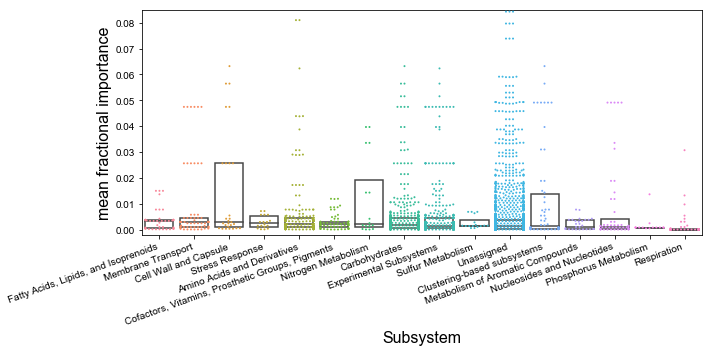

In [54]:
imp_order = subsys_to_swarmbox(classes, 
                   value_column = 'mean fractional importance',
                   subsystem_level='subsystem',
                   fname='../results/subsystems/subsystems_class_summary.svg',
                   ylim=(-0.002,0.085))

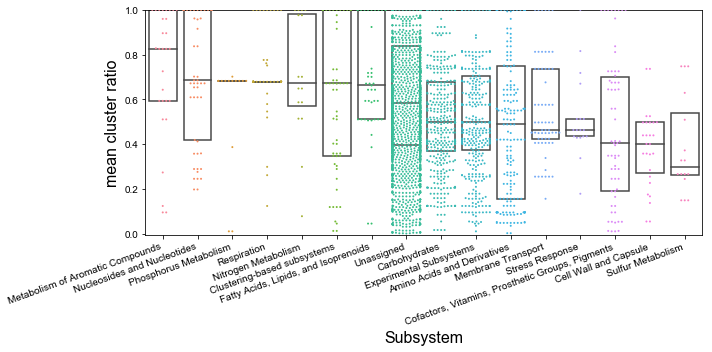

In [55]:
cr_order = subsys_to_swarmbox(classes, 
                   value_column = 'mean cluster ratio',
                   subsystem_level='subsystem',
                   fname='../results/subsystems/subsystems_class_cluster_ratio_summary.svg',
                   ylim=(-0.005,1))

In [13]:
# Perform Kruskal Wallis test for differences in population median.
from scipy import stats

print(stats.kruskal(*[classes[subsys]['mean fractional importance'] for 
   subsys in classes.keys() if 
   len(classes[subsys]['mean fractional importance']) > 10]))

print(stats.kruskal(*[classes[subsys]['mean cluster ratio'] for 
   subsys in classes.keys() if 
   len(classes[subsys]['mean cluster ratio']) > 10]))

KruskalResult(statistic=158.74680516599986, pvalue=4.3743526794739596e-26)
KruskalResult(statistic=151.79279743103712, pvalue=1.0622669653477582e-24)


In [14]:
# Both Kruskal Wallis tests were well below sig thresh, so do post-hoc pairwise dunn's tests
import scikit_posthocs as sp

def do_posthoc_dunns(subsys_dict,ordered_subsystems,value_column):
    all_data = []
    for subsys in ordered_subsystems:
        if len(subsys_dict[subsys][value_column]) > 10:
            all_data.append(subsys_dict[subsys][value_column])
            

    posthoc_result = sp.posthoc_dunn(all_data,p_adjust='bonferroni')
    posthoc_result.columns = ordered_subsystems
    posthoc_result.index = ordered_subsystems
    return posthoc_result

fractional_imp_posthoc = do_posthoc_dunns(classes,imp_order,value_column = 'mean fractional importance')
cluster_ratio_posthoc = do_posthoc_dunns(classes,cr_order,value_column = 'mean cluster ratio')
fractional_imp_posthoc.to_csv('../results/subsystems/posthoc_kw_fract_imp.csv', sep = ',')
cluster_ratio_posthoc.to_csv('../results/subsystems/posthoc_kw_cluster_ratio.csv', sep = ',')

In [15]:
fractional_imp_posthoc

,"Fatty Acids, Lipids, and Isoprenoids",Membrane Transport,Cell Wall and Capsule,Stress Response,Amino Acids and Derivatives,"Cofactors, Vitamins, Prosthetic Groups, Pigments",Nitrogen Metabolism,Carbohydrates,Experimental Subsystems,Sulfur Metabolism,Unassigned,Clustering-based subsystems,Metabolism of Aromatic Compounds,Nucleosides and Nucleotides,Phosphorus Metabolism,Respiration
"Fatty Acids, Lipids, and Isoprenoids",-1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000,7.469167e-10
Membrane Transport,1.000000e+00,-1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000,7.597498e-02,1.000000e+00,1.000000,8.712817e-01,1.000000,7.126308e-18
Cell Wall and Capsule,1.000000e+00,1.000000e+00,-1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000,2.799462e-01,1.000000e+00,0.642944,6.815043e-01,1.000000,1.193971e-12
Stress Response,1.000000e+00,1.000000e+00,1.000000e+00,-1.000000,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000,4.667959e-06
Amino Acids and Derivatives,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,-1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000,6.236321e-03,1.000000e+00,1.000000,1.000000e+00,1.000000,6.466698e-23
"Cofactors, Vitamins, Prosthetic Groups, Pigments",1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,-1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000,4.940343e-13
Nitrogen Metabolism,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,-1.000000,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000,1.287320e-06
Carbohydrates,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000,-1.000000e+00,1.000000e+00,1.000000,4.571033e-03,1.000000e+00,1.000000,1.000000e+00,1.000000,1.461291e-23
Experimental Subsystems,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,-1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000,2.806197e-20
Sulfur Metabolism,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,-1.000000,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000,1.394611e-05


In [16]:
cluster_ratio_posthoc

,Metabolism of Aromatic Compounds,Nucleosides and Nucleotides,Phosphorus Metabolism,Respiration,Nitrogen Metabolism,Clustering-based subsystems,"Fatty Acids, Lipids, and Isoprenoids",Unassigned,Carbohydrates,Experimental Subsystems,Amino Acids and Derivatives,Membrane Transport,Stress Response,"Cofactors, Vitamins, Prosthetic Groups, Pigments",Cell Wall and Capsule,Sulfur Metabolism
Metabolism of Aromatic Compounds,-1.000000,1.000000,1.0,1.000000e+00,1.000000,1.000000,1.000000,1.000000e+00,7.833526e-03,0.024104,1.263307e-03,0.321369,0.866354,0.003673,0.000204,0.006938
Nucleosides and Nucleotides,1.000000,-1.000000,1.0,1.000000e+00,1.000000,1.000000,1.000000,1.000000e+00,2.103194e-03,0.010360,2.502659e-04,0.492477,1.000000,0.002407,0.000170,0.011310
Phosphorus Metabolism,1.000000,1.000000,-1.0,1.000000e+00,1.000000,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000
Respiration,1.000000,1.000000,1.0,-1.000000e+00,1.000000,1.000000,1.000000,7.662190e-02,4.295155e-06,0.000042,4.876267e-07,0.033533,0.429113,0.000041,0.000006,0.001441
Nitrogen Metabolism,1.000000,1.000000,1.0,1.000000e+00,-1.000000,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000,3.720889e-01,1.000000,1.000000,0.370661,0.024455,0.145354
Clustering-based subsystems,1.000000,1.000000,1.0,1.000000e+00,1.000000,-1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000,6.712457e-01,1.000000,1.000000,1.000000,0.054088,0.619655
"Fatty Acids, Lipids, and Isoprenoids",1.000000,1.000000,1.0,1.000000e+00,1.000000,1.000000,-1.000000,1.000000e+00,6.294500e-03,0.024467,8.429913e-04,0.580337,1.000000,0.004347,0.000265,0.012525
Unassigned,1.000000,1.000000,1.0,7.662190e-02,1.000000,1.000000,1.000000,-1.000000e+00,3.777372e-07,0.000366,3.296731e-06,1.000000,1.000000,0.025273,0.002790,0.193174
Carbohydrates,0.007834,0.002103,1.0,4.295155e-06,1.000000,1.000000,0.006295,3.777372e-07,-1.000000e+00,1.000000,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000
Experimental Subsystems,0.024104,0.010360,1.0,4.241455e-05,1.000000,1.000000,0.024467,3.659765e-04,1.000000e+00,-1.000000,1.000000e+00,1.000000,1.000000,1.000000,0.546601,1.000000


In [17]:
# What's up with respiration? low fractional importance but high cluster ratio.
# Get all the respiration reactions
respiration_rxns = []
for reaction in sorted_df.index:
    if reaction in subsystems.index:
        info = pd.DataFrame(subsystems.loc[reaction]) # necessary for uniform processing
        # of both single entries and multiple entries, e.g. a reaction can have multiple assignments
        if len(info.columns) == 1:
            info = info.T
        # for each of the subsystems, add the fractional importance and cluster ratio means
        #for entry in info.index:
        
        for index, row in info.iterrows():
            if 'Respiration' in row['Class']:
                respiration_rxns.append(row['Reaction'])
respiration_rxns = list(set(respiration_rxns))

In [18]:
# Look at the idenitity of the Respiration reactions w/ top cluster ratios
sorted_df.loc[respiration_rxns].sort_values('mean cluster ratio', ascending = False)

,mean cluster ratio,mean fractional difference,mean fractional importance,species count,zero-weighted difference,zero-weighted importance,reaction string,subsystem class,subsystem sub-class,subsystem,role
rxn08528,1.000000,0.008146,0.000013,2,0.000562,8.631224e-07,Fumarate + 2-Demethylmenaquinol 8 <=> Succinat...,"[Carbohydrates, Carbohydrates, Carbohydrates, ...","[Central carbohydrate metabolism, Central carb...","[TCA_Cycle, TCA_Cycle, Serine-glyoxylate_cycle...",[Succinate dehydrogenase flavoprotein subunit ...
rxn00145,1.000000,0.002757,0.000078,3,0.000285,8.046164e-06,2.0 Cytochrome c3+ + L-Lactate <=> Pyruvate + ...,"[Carbohydrates, Carbohydrates, Carbohydrates, ...","[Fermentation, Fermentation, Organic acids, -,...","[Fermentations:_Lactate, Fermentations:_Mixed_...","[L-lactate dehydrogenase (EC 1.1.1.27), L-lact..."
rxn00157,0.776213,0.023536,0.003008,7,0.005681,7.260493e-04,Acetyl-CoA + Formate <=> CoA + Pyruvate,"[Amino Acids and Derivatives, Amino Acids and ...","[Lysine, threonine, methionine, and cysteine, ...","[Threonine_anaerobic_catabolism_gene_cluster, ...","[Pyruvate formate-lyase (EC 2.3.1.54), Pyruvat..."
rxn05559,0.761327,0.013096,0.000494,5,0.002258,8.524716e-05,Formate + H+ <=> Formate + H+,"[Carbohydrates, Experimental Subsystems, Exper...","[Fermentation, -, -, -]","[Fermentations:_Mixed_acid, Transporters_In_Mo...",[Formate efflux transporter (TC 2.A.44 family)...
rxn04794,0.751426,0.224789,0.030695,7,0.054259,7.409226e-03,CoA + 2-Oxobutyrate <=> Formate + Propionyl-CoA,"[Amino Acids and Derivatives, Amino Acids and ...","[Lysine, threonine, methionine, and cysteine, ...","[Threonine_anaerobic_catabolism_gene_cluster, ...","[2-ketobutyrate formate-lyase (EC 2.3.1.-), Py..."
rxn00058,0.678536,0.002927,0.000003,3,0.000303,3.487463e-07,O2 + 4.0 H+ + 4.0 Cytochrome c2+ <=> 2.0 H2O +...,"[Experimental Subsystems, Experimental Subsyst...","[-, -, -, -, -, -, -, -, -, -, -, Electron acc...","[Transporters_In_Models, Transporters_In_Model...",[Cytochrome c oxidase polypeptide I (EC 1.9.3....
rxn08793,0.625787,0.016748,0.000973,4,0.002310,1.342485e-04,L-Lactate + Menaquinone 8 --> Pyruvate + Menaq...,"[Carbohydrates, Carbohydrates, Carbohydrates, ...","[Fermentation, Fermentation, Organic acids, -,...","[Fermentations:_Lactate, Fermentations:_Mixed_...","[L-lactate dehydrogenase (EC 1.1.1.27), L-lact..."
rxn08792,0.579007,0.018538,0.000961,5,0.003196,1.656354e-04,L-Lactate + Ubiquinone-8 --> Pyruvate + Ubiqui...,"[Carbohydrates, Carbohydrates, Carbohydrates, ...","[Fermentation, Fermentation, Organic acids, -,...","[Fermentations:_Lactate, Fermentations:_Mixed_...","[L-lactate dehydrogenase (EC 1.1.1.27), L-lact..."
rxn08291,0.545714,0.076996,0.005375,3,0.007965,5.560628e-04,H2O + FAD + H+ + D-Alanine <=> NH3 + Pyruvate ...,"[Amino Acids and Derivatives, Carbohydrates, C...","[Proline and 4-hydroxyproline, Central carbohy...","[Proline,_4-hydroxyproline_uptake_and_utilizat...",[D-amino acid dehydrogenase small subunit (EC ...
rxn00499,0.518999,0.069982,0.009708,6,0.014479,2.008552e-03,NAD + L-Lactate <=> NADH + Pyruvate + H+,"[Carbohydrates, Carbohydrates, Carbohydrates, ...","[Fermentation, Fermentation, Organic acids, -,...","[Fermentations:_Lactate, Fermentations:_Mixed_...","[L-lactate dehydrogenase (EC 1.1.1.27), L-lact..."


In [19]:
# generate tables with summary means for each subsystem level
def generate_subsystem_summary(subsystem_dict):
    subsystem_summary_table = pd.concat(
          [pd.DataFrame(subsystem_dict).T['mean fractional importance'].apply(np.mean),
           pd.DataFrame(subsystem_dict).T['mean cluster ratio'].apply(np.mean),
           pd.DataFrame(subsystem_dict).T['reaction count']],
           axis = 1)
    subsystem_summary_table = subsystem_summary_table.sort_values(by=['mean fractional importance','mean cluster ratio'], ascending=[False,True])
    return subsystem_summary_table

subsystem_summary_table = generate_subsystem_summary(subsystem_names)
subsystem_summary_table.to_csv('../results/subsystems/subsystem_names_table.tsv', sep='\t')
subsystem_summary_table = generate_subsystem_summary(subclasses)
subsystem_summary_table.to_csv('../results/subsystems/subsystem_subclasses_table.tsv', sep='\t')
subsystem_summary_table = generate_subsystem_summary(classes)
subsystem_summary_table.to_csv('../results/subsystems/subsystem_classes_table.tsv', sep='\t')

In [20]:
sorted_met_df = met_target_df.sort_values(by=['mean fractional importance','mean cluster ratio'], ascending=[False,True])
# add a metabolite name
met_strings = []
univ_mets = [met.id for met in universal.metabolites]
for metabolite in sorted_met_df.index:
    if metabolite in univ_mets:
        met_as_string = universal.metabolites.get_by_id(metabolite).name
    else:
        met_as_string = 'metabolite missing from universal'
    met_strings.append(met_as_string)
sorted_met_df['name'] = met_strings

sorted_met_df.to_csv('../results/classification_results/panspecies_metabolite_means.csv', sep=',')

In [21]:
# Which metabolites are in reactions with the highest mean fractional importance?
sorted_met_df

,mean cluster ratio,mean fractional importance,number of reactions,name
cpd00363_c,1.000000,0.059156,1,Ethanol
cpd01466_c,0.531462,0.051050,24,Maleylpyruvate
cpd01560_c,0.681523,0.045827,7,beta-Alanyl-CoA
cpd00248_e,0.528472,0.045603,7,Quinate
cpd02211_c,1.000000,0.043897,2,L-2-Amino-acetoacetate
cpd01501_c,0.729370,0.043675,13,2-Methylcitrate
cpd00269_c,0.627158,0.040591,17,2-Oxoadipate
cpd03389_c,0.830363,0.038727,18,Selenocysteine
cpd03397_c,0.799606,0.038315,20,Selenohomocysteine
cpd03398_c,0.799606,0.038315,20,Selenocystathionine


In [22]:
# set the matplotlib defaults again, which get reset by seaborn.
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker as mticker
matplotlib.rcParams["savefig.dpi"] = 300
matplotlib.rcParams['figure.dpi'] = 300
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"

SMALLER_SIZE = 8
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 16

matplotlib.rc('font', size=SMALL_SIZE)          # controls default text sizes
matplotlib.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
matplotlib.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
matplotlib.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=SMALLER_SIZE)    # legend fontsize
matplotlib.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


In [23]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline


def scatter_curation_targets(df,xvar,yvar,fname,sizevar=None,title=None,italics=False):
    fig,ax = plt.subplots()

    x = df[xvar].values
    y = df[yvar].values
    
    if sizevar:
        s = df[sizevar].values*10
    else:
        s = 100
    
    ax.scatter(x,y,s=s, alpha = 0.3, color = 'black')
    pad = 0.01
    ax.set_xlim((-1.0*pad,max(x)+pad))
    ax.set_ylim((0,max(y)))
    ax.set_xlabel(xvar)
    ax.set_ylabel(yvar)
    if italics:
        ax.set_title(title, style='italic')
    else:
        ax.set_title(title)
    fig.set_size_inches(5,3.5)
    plt.tight_layout()
    fig.savefig(fname)
    return ax

def scatter_curation_targets_for_multipanel(df,ax,xvar,yvar,sizevar=None,title=None,italics=False):
    # Only for multipanel plotting. Override default fonts.
    x = df[xvar].values
    y = df[yvar].values
    
    if sizevar:
        s = df[sizevar].values*10
    else:
        s = 100
    
    ax.scatter(x,y,s=20, alpha = 0.3, color = 'black')
    pad = 0.01
    ax.set_xlim((-1.0*pad,max(x)+pad))
    ax.set_ylim((0,max(y)))
    ax.set_xlabel(xvar, fontsize = 8)
    ax.set_ylabel(yvar, fontsize = 8)
    ax.tick_params(axis='both', which='major', labelsize=8)
    if italics:
        ax.set_title(title, style='italic',fontsize = 10)
    else:
        ax.set_title(title)
    return ax

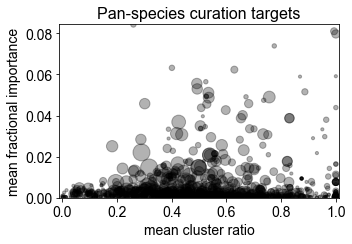

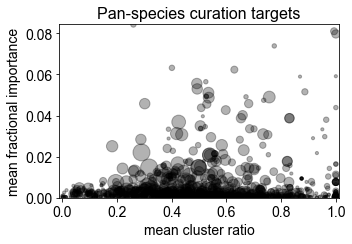

In [24]:
xvar = 'mean cluster ratio'
yvar = 'mean fractional importance'
df = sorted_df
sizevar = 'species count'
fname = '../results/curation_target_plots/panspecies.svg'
all_ax = scatter_curation_targets(sorted_df,xvar,yvar,fname,sizevar,title='Pan-species curation targets')
fname = '../results/curation_target_plots/panspecies.png'
all_ax = scatter_curation_targets(sorted_df,xvar,yvar,fname,sizevar,title='Pan-species curation targets')

/home/greg/Envs/ssl_ensembles/lib/python3.5/site-packages/matplotlib/pyplot.py:514 RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


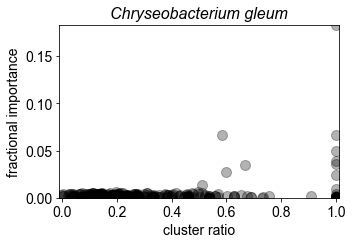

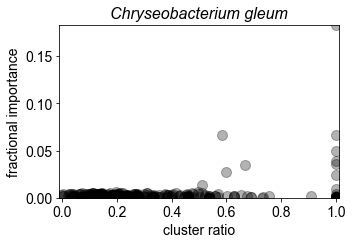

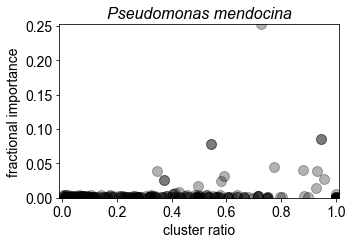

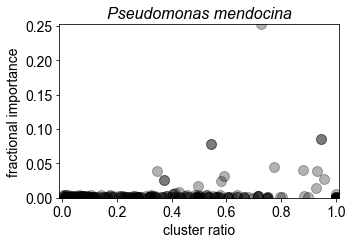

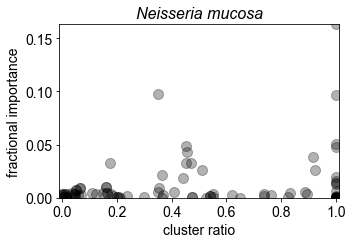

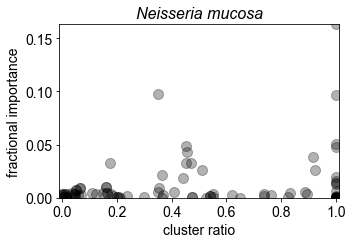

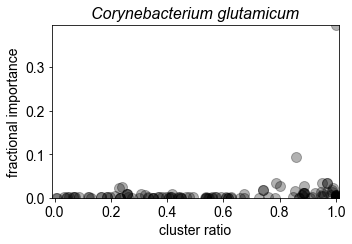

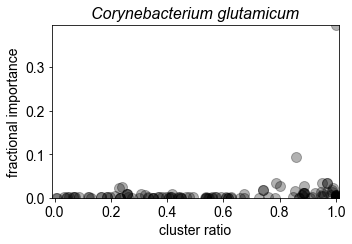

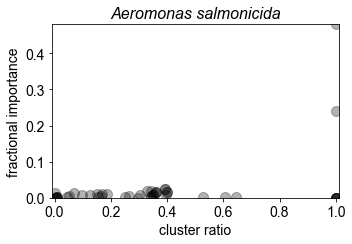

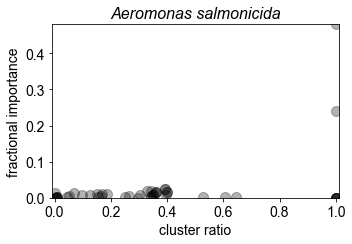

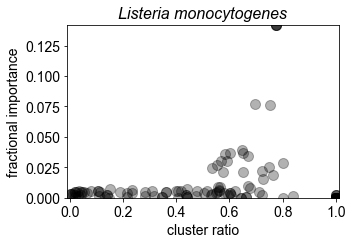

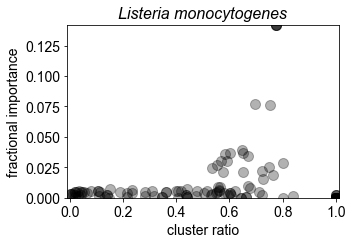

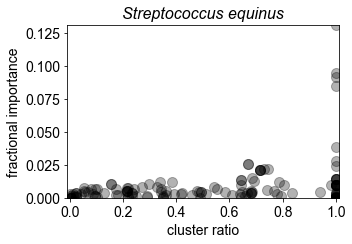

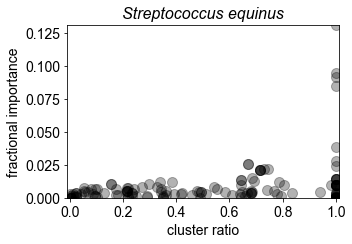

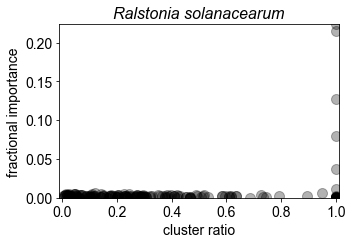

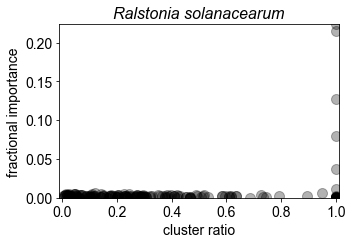

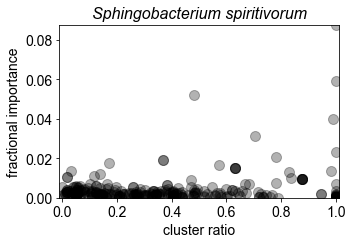

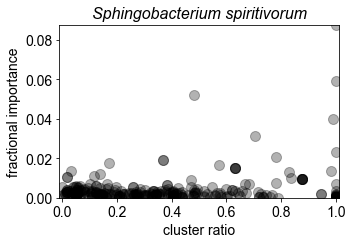

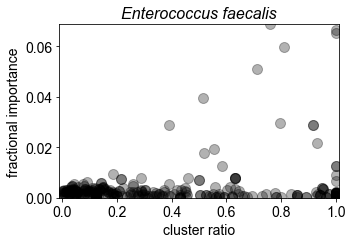

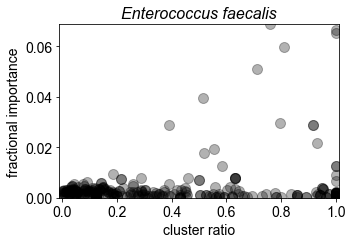

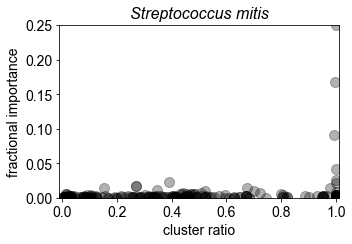

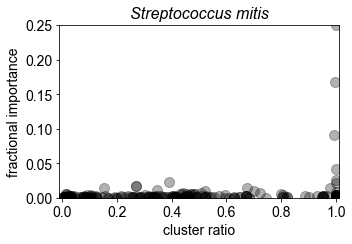

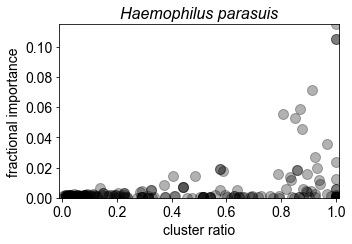

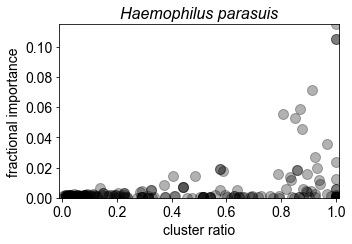

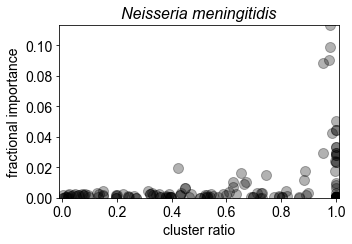

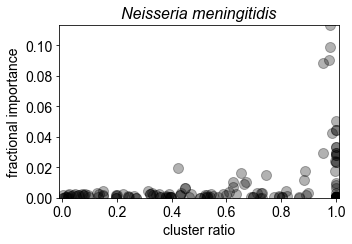

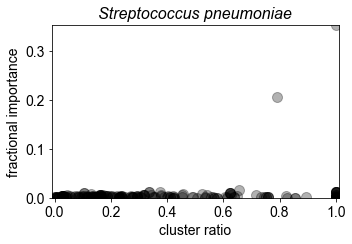

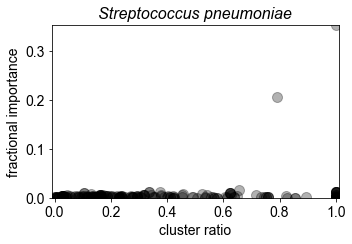

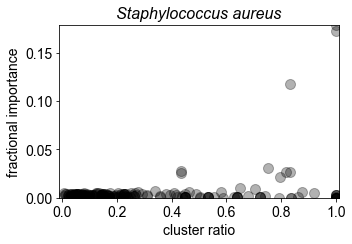

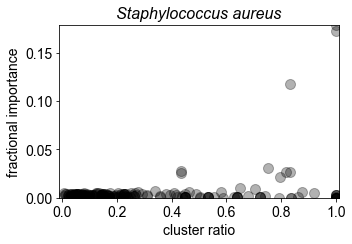

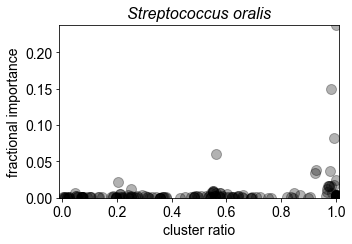

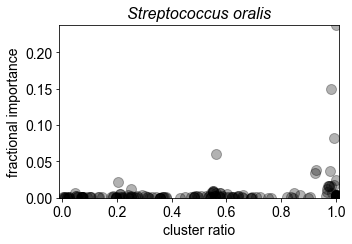

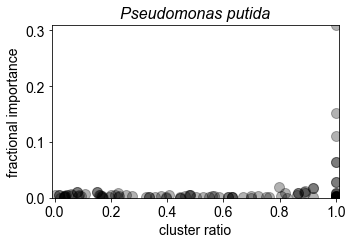

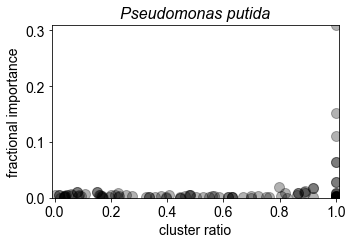

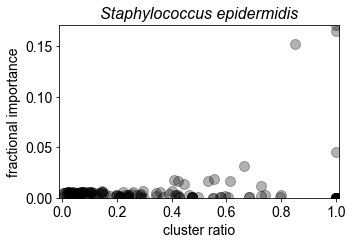

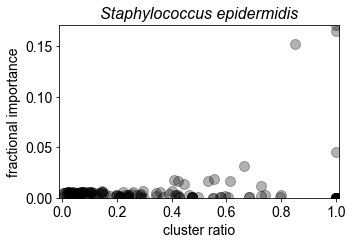

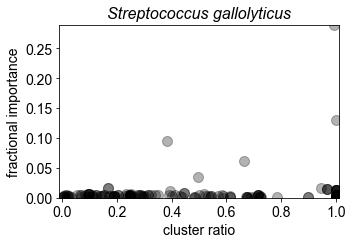

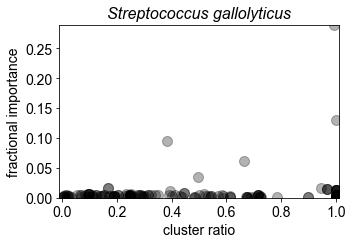

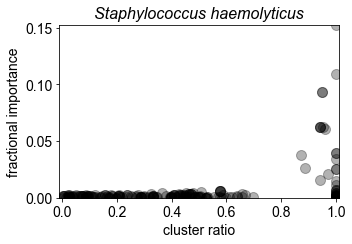

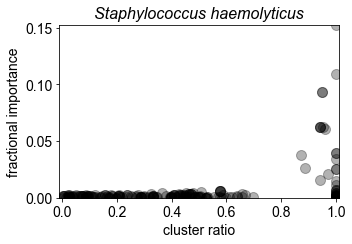

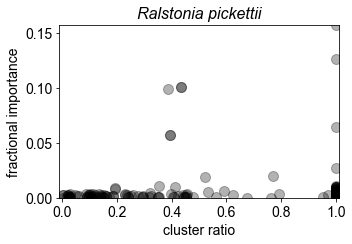

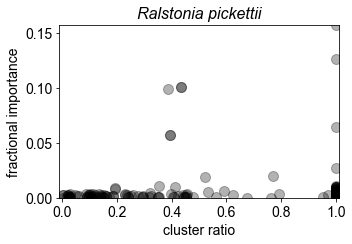

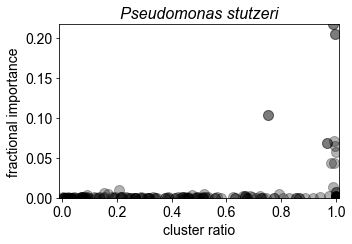

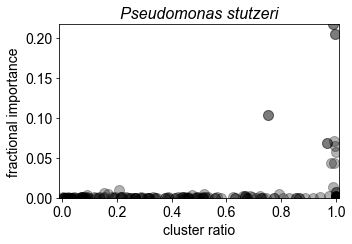

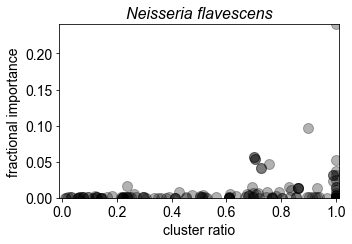

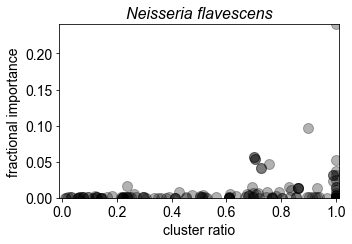

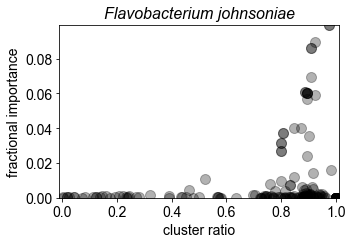

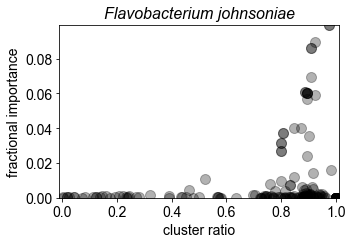

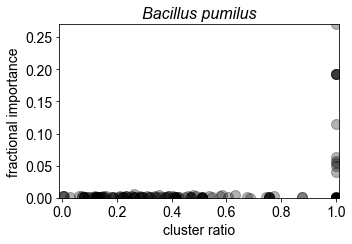

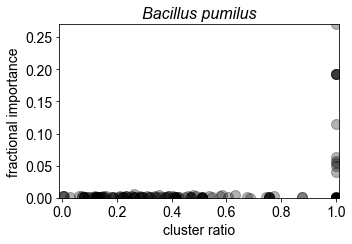

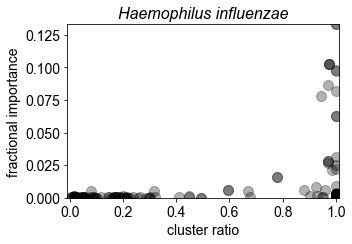

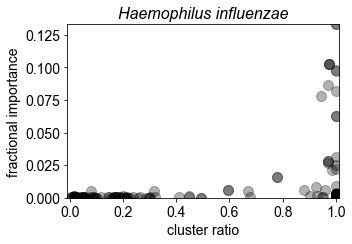

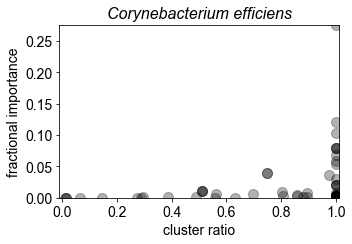

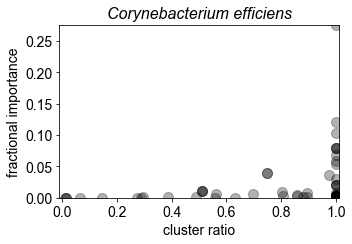

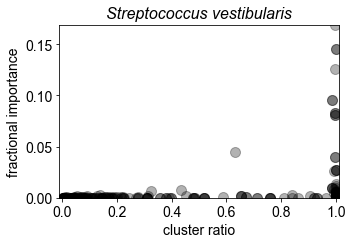

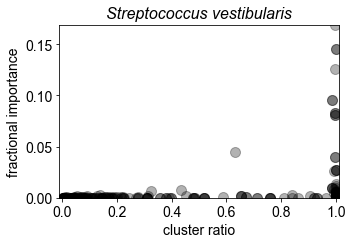

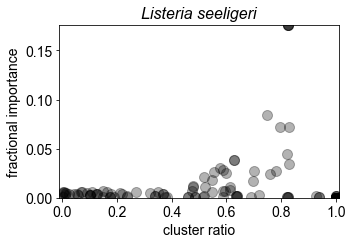

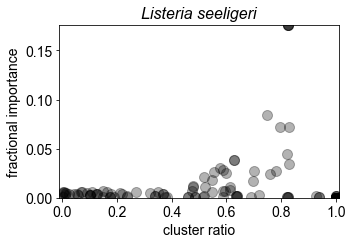

In [25]:
xvar = 'cluster ratio'
yvar = 'fractional importance'
axes = {}
for species in species_curation_dfs.keys():
    
    df = species_curation_dfs[species]
    fname = '../results/curation_target_plots/'+species+'_curation_targets.png'
    axes[species] = scatter_curation_targets(df,xvar,yvar,fname,title=species,italics=True)
    fname = '../results/curation_target_plots/'+species+'_curation_targets.svg'
    axes[species] = scatter_curation_targets(df,xvar,yvar,fname,title=species,italics=True)

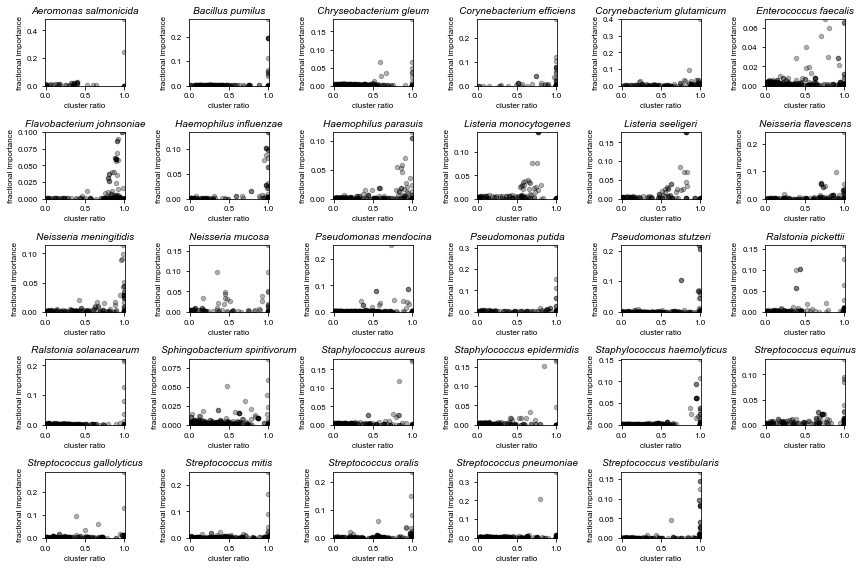

In [26]:
# repeat, generating a single multi-panel figure
xvar = 'cluster ratio'
yvar = 'fractional importance'
fig, axes = plt.subplots(5,6)
axes = np.ravel(axes)

sorted_species = list(species_curation_dfs.keys())
sorted_species.sort() # modified in-place

i = 0
for species in sorted_species:
    
    df = species_curation_dfs[species]
    scatter_curation_targets_for_multipanel(df,axes[i],xvar,yvar,title=species,italics=True)
    i += 1

while i < len(axes):
    fig.delaxes(axes[i])
    i += 1
    
fname = '../results/curation_target_plots/all_multipanel_curation_targets'
fig.set_size_inches(12,8)
fig.tight_layout()
fig.savefig(fname+'.svg')
fig.savefig(fname+'.png')